# Home appraisal prediction
Arthur Brouwers
This notebook is about iteration 0 for my personal challenge in semester 4 of AI. It aims to predict the house price correctly. Since I do not know which model I can use the best, I am using nearest neighbors since this was adviced. 

![Alt text](https://www.smartpropertyinvestment.com.au/images/intro-images/839x487/property-financing-prices-spi.jpg)

In [462]:
import io, math
from scipy.io import arff
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error      
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd


Now let's import the found dataset

In [463]:
columns = ["Address", "City", "Price", "Lot size (m2)", "Living space size (m2)", "Build year", "Build type", "House type", "Roof", "Rooms", "Toilet", "Floors", "Energy label", "Position", "Garden", "Estimated neighbourhood price per m2"]
df = pandas.read_csv("C:/school/leerjaar 2/semester 4/Personal challenge/raw_data.csv", names=columns)
df.shape

(5556, 16)

In [464]:
print(df.isna().sum())


Address                                   0
City                                      0
Price                                     0
Lot size (m2)                             0
Living space size (m2)                    0
Build year                               84
Build type                                0
House type                                0
Roof                                      0
Rooms                                     0
Toilet                                    0
Floors                                    0
Energy label                              0
Position                                304
Garden                                   58
Estimated neighbourhood price per m2    169
dtype: int64


As you can see some of the values are missing (if it does not say 0, there is possibly missing data). So it is necessary to clean the dataset. 

In [465]:
# Load the data from the CSV file
df = pd.read_csv('C:/school/leerjaar 2/semester 4/Personal challenge/raw_data.csv')

# Drop rows where "Price" is "Prijs op aanvraag"
df_filtered = df[df['Price'] != 'Prijs op aanvraag']

# Clean the "Price" column to keep only numeric characters
df_filtered["Price"] = df_filtered["Price"].str.replace('[^0-9]', '', regex=True)

# Convert the "Price" column to an integer
df_filtered["Price"] = df_filtered["Price"].astype(int)

# Continue with the other data cleaning and conversions as you did before
df_filtered['Rooms'] = df_filtered['Rooms'].str.extract('(\d+)').astype(float)
df_filtered['Toilet'] = df_filtered['Toilet'].str.extract('(\d+)').astype(float)
df_filtered['Floors'] = df_filtered['Floors'].str.extract('(\d+)').astype(float)
df_filtered['Lot size (m2)'] = df_filtered['Lot size (m2)'].str.replace(' m²', '').astype(float)
df_filtered['Living space size (m2)'] = df_filtered['Living space size (m2)'].str.replace(' m²', '').astype(float)
df_filtered['Build year'] = pd.to_numeric(df_filtered['Build year'], errors='coerce')
df_filtered["Estimated neighbourhood price per m2"] = df_filtered["Estimated neighbourhood price per m2"].str.replace('[^\d]', '', regex=True)
df_filtered["Estimated neighbourhood price per m2"] = df_filtered["Estimated neighbourhood price per m2"].astype(float)


energy_label_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
df_filtered['Energy label'] = df_filtered['Energy label'].map(energy_label_mapping)
# Drop rows with NaN values in the "Energy label" column
df_filtered.dropna(inplace=True)

df_filtered.shape
df_filtered.sample(10)

C:\Users\arthu\AppData\Local\Temp\ipykernel_15024\2668143011.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Price"] = df_filtered["Price"].str.replace('[^0-9]', '', regex=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_15024\2668143011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Price"] = df_filtered["Price"].astype(int)
C:\Users\arthu\AppData\Local\Temp\ipykernel_15024\2668143011.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,Address,City,Price,Lot size (m2),Living space size (m2),Build year,Build type,House type,Roof,Rooms,Toilet,Floors,Energy label,Position,Garden,Estimated neighbourhood price per m2
5048,Borssenburg 34,Amstelveen,650000,134.000,130.0,1958.0,Bestaande bouw,"Eengezinswoning, tussenwoning",Zadeldak bedekt met pannen,6.0,1.0,3.0,2.0,In woonwijk,Achtertuin,1795.0
3188,Vinkelsestraat 35,Heesch,675000,876.000,146.0,1978.0,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Schilddak bedekt met pannen,6.0,1.0,3.0,3.0,Open ligging en vrij uitzicht,Tuin rondom,1275.0
2734,Kruiskamp 11,Swalmen,625000,6.830,202.0,1920.0,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Zadeldak bedekt met pannen,10.0,1.0,2.0,1.0,In woonwijk en vrij uitzicht,Achtertuin en voortuin,1500.0
509,Beukestraat 3,Krommenie,340000,119.000,88.0,1935.0,Bestaande bouw,"Eengezinswoning, geschakelde 2-onder-1-kapwoning",Zadeldak bedekt met pannen,4.0,1.0,3.0,1.0,Aan rustige weg en in woonwijk,"Achtertuin, voortuin en zijtuin",2665.0
2036,Hoofdstraat 25 B,Hooghalen,650000,1.836,184.0,1978.0,Bestaande bouw,"Bungalow, vrijstaande woning",Zadeldak bedekt met riet,5.0,2.0,2.0,3.0,"Aan bosrand, beschutte ligging, in bosrijke om...",Tuin rondom,835.0
766,Hertenhoek 18,Prinsenbeek,439500,203.000,100.0,1967.0,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,4.0,1.0,2.0,2.0,"Aan park, aan rustige weg en in woonwijk",Achtertuin en voortuin,11035.0
4054,Zandschelstraat 14,Goirle,345000,250.000,101.0,1930.0,Bestaande bouw,"Eengezinswoning, hoekwoning",Zadeldak bedekt met pannen,4.0,1.0,2.0,3.0,Aan rustige weg,Achtertuin en voortuin,115.0
1457,Evert van 't Landstraat 37,Apeldoorn,479500,120.000,122.0,2018.0,Bestaande bouw,"Eengezinswoning, tussenwoning",Zadeldak bedekt met pannen,5.0,1.0,3.0,5.0,Aan rustige weg en in woonwijk,Achtertuin en voortuin,195.0
1199,Jacob van Ruysdaellaan 23,Lochem,245000,142.000,89.0,1966.0,Bestaande bouw,"Eengezinswoning, tussenwoning",Zadeldak bedekt met pannen,5.0,1.0,2.0,3.0,In woonwijk,Achtertuin en voortuin,3910.0
427,Achtererf 73,Tholen,359900,113.000,142.0,2003.0,Bestaande bouw,"Eengezinswoning, eindwoning (waterwoning)",Zadeldak bedekt met pannen,4.0,1.0,2.0,5.0,Aan rustige weg en in woonwijk,Achtertuin en voortuin,7710.0


This seems to solve the incorrect/missing data. By using the function "dropna", the data will no longer contain rows with missing data. This is confirmed by the shape funtion that shows that the amount of rows of df_filtered is less than the amount of rows in df. 

In [466]:
numeric_features = ['Price', "Lot size (m2)", "Living space size (m2)", "Build year", "Rooms", "Toilet", "Floors", "Energy label", "Estimated neighbourhood price per m2"]
target = "Price"
X = df_filtered[numeric_features]
y = df_filtered[target]

In [467]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 4274 observations, of which 3419 are now in the train set, and 855 in the test set.


# Feature Selection
I will use a heatmap to select a suitable set of features to make predictions. 

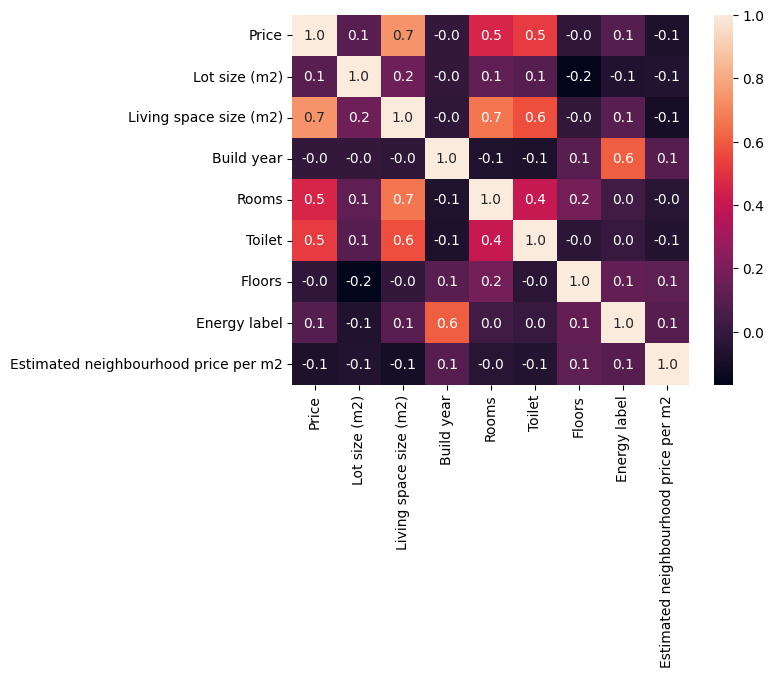

In [468]:
correlations = X_train.corr()
plot = sns.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

# Scatterplot

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


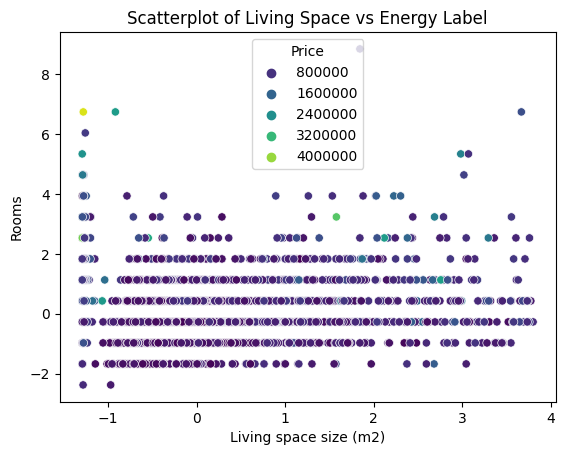

In [469]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


plot = sns.scatterplot(x=X_train[:,1], y=X_train[:,4], hue=y_train, palette="viridis")
plot.set(xlabel="Living space size (m2)", ylabel="Rooms", title="Scatterplot of Living Space vs Energy Label")
plot.legend(title="Price")

# Create the scatterplot




# Accuracy
What is the accuracy and how did I get the best K-value?

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 4274 observations, of which 3419 are now in the train set, and 855 in the test set.


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.

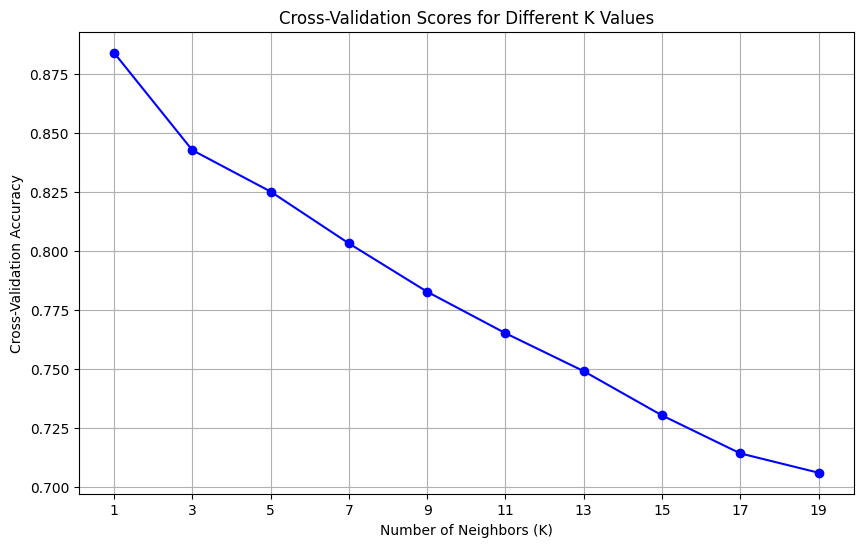

Best K value: 1


In [471]:
k_values = list(range(1, 20, 2))
cv_scores = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # You can adjust the number of folds (cv) as needed
    cv_scores.append(scores.mean())
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Scores for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# print which K value results in the highest cross-validation score
best_k = k_values[np.argmax(cv_scores)]
print(f'Best K value: {best_k}')

In [472]:
# train model with the best K value
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [473]:
test_accuracy = best_model.score(X_test, y_test)
print(f'Accuracy on test data with the best K: {test_accuracy:.4f}')


Accuracy on test data with the best K: 0.8819
